# Importing the necessary libraries

In [1]:
# Import libraries
import requests
import pandas as pd
import numpy as np
import datetime as dt
import sys, os

#!pip install quandl
import quandl

#!pip install yfinance
import yfinance as yf

#!pip install pandas-datareader
from pandas_datareader import data as pdr

# API Credentials
# Note - this is a paid student license, and this API key and resulting data may not be distributed beyond the grading of the project
quandl.ApiConfig.api_key = 'Xgwh__VbLXMscAH-oiFi'

# Functions to gather data for analysis and visualization

In [2]:
# S&P 500 Scraper

def sp500_list_retrieval():
  """
  Retrieve the S&P 500 list from the corresponding Wikipedia page.

  Returns a dataframe of all tickers and corresponding industry information.
  """
  print("Acquiring S&P500 Tickers list.")

  table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

  df = table[0]
  df.columns = ['Symbol', 
                'Security', 
                'SEC filings', 
                'GICS Sector', 
                'GICS Sub Industry', 
                'Headquarters Location', 
                'Date First Added', 
                'CIK', 
                'Founded'
                ]
  df.drop(labels=['SEC filings', 
                  'Headquarters Location', 
                  'Date First Added', 
                  'CIK'
                  ], 
          axis=1, 
          inplace=True
          )

  return df

In [3]:
from datetime import date

# Fundamental Data Pull from Quandl

def fundamentals_data_pull(timeframe='MRT', ticker=[], start_yr='2015', end_date=None):
  """Pull the fundamentals data for each ticker passed through. If no timeframe
  is selected, all timeframes (dimensions) will be pulled. Otherwise, timeframes
  may be selected from one of the following:

  Select One:
  - AR (As Reported)
  - MR (Most-Recent Reported)

  + One of the Following
  - Y (Annual)
  - T (Trailing Twelve Months)
  - Q (Quarterly)
  (i.e. MRY = Most-Recent Reported Annual Data)

  Keyword Arguments:
  timeframe -- one of the above (default 'MRT')
  ticker -- list of stock tickers (default empty list)

  Returns:
  dict -- keys are tickers, values are dataframe of all Quandl fundamentals data for designated timeframe
  """
  
  print("Acquiring fundamentals data for tickers.")
  
  # Reduce dataset only to years requested
  cutoff_date = str(start_yr + "-01-01")
  #cutoff_date = pd.to_datetime(start_yr + "-01-01")
  #df = df[df['reportperiod'] > cutoff_date]

  if timeframe == None:
    timeframe = input("Please select a timeframe from 'MRT', 'ART','ARY', or 'MRY':  ")
    #df = quandl.get_table('SHARADAR/SF1', ticker=ticker)
    # Removing to eliminate confusion with Quarterly results and potential incompatibility down the line -- AB 9/14
  
  elif timeframe in ['MRT', 'ART','ARY', 'MRY']:
    if end_date == None:
      end_date = str(date.today())
      df = quandl.get_table('SHARADAR/SF1', dimension=timeframe, calendardate={'gte': cutoff_date, 'lte' : end_date}, ticker=ticker, paginate=True)
    else:
      df = quandl.get_table('SHARADAR/SF1', dimension=timeframe, calendardate={'gte': cutoff_date, 'lte' : end_date}, ticker=ticker, paginate=True)
  
  elif timeframe in ['MRQ', 'ARQ']:
    raise ValueError("Quarterly data is not compatible with this analysis. Please select a timeframe from 'MRT', 'ART','ARY', or 'MRY'")

  else:
    timeframe = input("Please select a timeframe from 'MRT', 'ART','ARY', or 'MRY':  ")


  # Create a dictionary where keys are tickers and values are dataframes of fundamentals
  fund_dict = {}
  for x in ticker:
    df0 = df.copy()
    df0 = df0[df0['ticker'] == x.upper()]
    if len(df0) == 0:
      print("No data provided for symbol '" + x.upper() + "'")
      pass
    else:
      fund_dict[x.upper()] = df0

  return fund_dict


# Pricing Data Pull from yfinance

def pricing_data(fund_dict):
  """Pull the pricing data for each ticker.

  Keyword Arguments:
  fund_dict -- dict, dictionary where k,v pairs are ticker,fundamental_data pairs

  Returns:
  dict -- keys are tickers
  """

  class HiddenPrints():
    def __enter__(self):
      self._original_stdout = sys.stdout
      sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
      sys.stdout.close()
      sys.stdout = self._original_stdout

  print("Acquiring pricing data for tickers.")

  #current_price = {}
  to_del = []
  # Iterate through dictionary pulling data for that symbol, joining to 
  # corresponding fundamentals dataframe.
  for k in fund_dict:
    start_date = min(fund_dict[k]['reportperiod'])
    #end_date = max(fund_dict[k]['reportperiod'])
    end_date = date.today()

    with HiddenPrints():
      data = yf.download(k, start=start_date, end=end_date)
    
    if len(data) > 0:
      current_price = data['Close'].iloc[-1]
      data.reset_index(inplace=True)
      data.rename(columns={"Date" : "reportperiod"}, inplace=True)

      # Sometimes quarter end/reporting period end is not on trading day, will take most recent closing price.
      # To do this, we will do an outer join of all data, sort by date, backfill data, then eliminate
      # all rows that did not have corresponding reporting data to restore original set + pricing.
      fund_dict[k] = pd.merge(fund_dict[k], data, left_on='reportperiod', right_on='reportperiod', how='outer', sort=False)
      fund_dict[k].sort_values('reportperiod',ascending=False,inplace=True)
      fund_dict[k][['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = fund_dict[k][['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].bfill() 
      fund_dict[k].dropna(axis=0, subset=['ticker'], inplace=True)
      fund_dict[k]['Current_Price'] = current_price
  
    elif len(data) == 0:
      to_del.append(k)
      pass

  print("Deleting tickers " + str(to_del) + " from dataset due to insufficient pricing data.")
  for k in to_del:
    del fund_dict[k]

  print("S&P Ticker Count after Data Acquisition:  " + str(len(fund_dict.keys())))

  return fund_dict

In [4]:
# Filtering Metrics

# If you would like to add additional calculations and criteria to your strategy,
# here is where you would add it.

# Make sure any filtering columns are boolean values (True/False) and are labeled
# with "filter_" for later dynamic dataframe filtering.

def pos_yoy_eps(df,timeframe='MRT',eps_type='epsdil'):
  """Adds a column with a boolean value indicating if yoy eps is positive.

  Keyword Arguments:
  df
  timeframe -- str, dimension being used throughout
  eps_type -- str, 'eps' (basic) or 'epsdil' (diluted)

  Returns:
  df -- dataframe with added boolean column for positive year-over-year eps.
  """

  if timeframe in ['MRT', 'ART']:
    df.sort_values('reportperiod',ascending=False,inplace=True)
    df['filter_pos_yoy_eps'] = np.where(df[eps_type] > df[eps_type].shift(-4), True, False)
  
  elif timeframe in ['ARY', 'MRY']:
      df.sort_values('reportperiod',ascending=False,inplace=True)
      df['filter_pos_yoy_eps'] = np.where(df[eps_type] > df[eps_type].shift(-1), True, False)

  return df


def roe(df, threshold=0.00):
  """ 
  Returns ROE as a calculated column (Net Income / Shareholder Equity [Avg])

  Keyword Arguments:
  df
  threshold -- float, percent ROE as decimal threshold (above=True, below=False)

  Returns:
  df -- dataframe with added 'roe_calc' float column and 'roe_thresh' boolean column
  """

  df['roe_calc'] = df['netinccmnusd'] / df['equityavg']
  df['filter_roe_thresh'] = np.where(df['roe_calc'] >= threshold, True, False)

  return df
  
def pos_yoy_roa(df,timeframe='MRT'):
  """Adds a column with a boolean value indicating if yoy roa is positive.

  Keyword Arguments:
  df
  timeframe -- str, dimension being used throughout

  Returns:
  df -- dataframe with added boolean column for positive year-over-year roa.
  """

  df['roa_calc'] = df['netinccmnusd'] / df['assetsavg']
  
  if timeframe in ['MRT', 'ART']:
    df.sort_values('reportperiod',ascending=False,inplace=True)
    df['filter_pos_yoy_roa'] = np.where(df['roa_calc'] > df['roa_calc'].shift(-4), True, False)
  
  elif timeframe in ['ARY', 'MRY']:
      df.sort_values('reportperiod',ascending=False,inplace=True)
      df['filter_pos_yoy_roa'] = np.where(df['roa_calc'] > df['roa_calc'].shift(-1), True, False)
  
  del df['roa_calc']

  return df

# Price Target Metrics

def pb_price_target(df):
  """ Returns columns for book value per share (price-to-book price target, pb_pt),
  boolean value for whether price to book (pb) is less than 1 (pb_value), and 
  the percentage below price-to-book.
  """

  df['pb_pt'] = df['bvps']
  df['filter_pb_value'] = np.where((df['pb'] < 1) & (df['pb'] > 0), True, False)
  df['filter_pb_price_target'] = np.where((df['pb_pt'] > df['Current_Price']), True, False)
  df['pb_pt_pct_below'] = np.where(df['filter_pb_value'] == True, 1 - (df['Current_Price'] / df['pb_pt']), 0)

  return df


In [5]:
# Aggregation and Dataset Reduction

def metrics_aggregation(df, timeframe='MRT', eps_type='epsdil', roe_threshold=0.10):
  """Returns dataframe aggregating all of the filtering and price targets.
  """
  ## Add any additional filtering metrics here with any relevant
  # Answers objective: Postiive Year-Over-Year Earnings Per Share (EPS)
  df = pos_yoy_eps(df, timeframe=timeframe, eps_type=eps_type)
  
  # Answers objective: Return on Equity > 10%
  df = roe(df, threshold=roe_threshold)
  
  # Answers objective: Return on Assets Increased over Previous Year
  df = pos_yoy_roa(df, timeframe=timeframe)

  # Answers objective: Price Target
  df = pb_price_target(df)

  return df
  

def most_recent(fund_dict):
  """Returns a dataframe of the most recent valuation data from each ticker in
  the dictionary passed through.
  """
  
  print("Pulling most recent observations.")
  
  data = []

  for k in fund_dict:
    fund_dict[k].sort_values('reportperiod',ascending=False,inplace=True)
    row = fund_dict[k].iloc[0]
    data.append(row)
  
  df = pd.DataFrame(data=data)

  return df

# Preparing a dataframe for producing visualizations

In [6]:
## Modifying to include additional colums for visualizations ...

def viz_output(df):

  ticker_info = sp500_list_retrieval()

  df = pd.merge(df, ticker_info, left_on='ticker', right_on='Symbol', how='left', sort=False)
  df.sort_values(by='pb_pt_pct_below', ascending=False, inplace=True)

  df = df[['Symbol', 
           'Security', 
           'GICS Sector', 
           'Current_Price', 
           'pb_pt_pct_below',
           'pb_pt', 
           'eps',
           'roa', 
           'roe', 
           'assetturnover', 
           'de', 
           'divyield', 
           'pe',
           'filter_pos_yoy_eps',
           'filter_roe_thresh',
           'filter_pos_yoy_roa',
           'filter_pb_value',
           'filter_pb_price_target'
           ]]

  df.rename(columns={'Current_Price' : 'Current Price',
                     'pb_pt_pct_below' : '% Below Price Target',
                     'pb_pt' : 'Price Target',
                     'eps' : 'EPS',
                     'roa' : 'ROA',
                     'roe' : 'ROE',
                     'assetturnover' : 'Asset Turnover',
                     'de' : 'Debt-to-Equity',
                     'divyield' : 'Dividend Yield',
                     'pe' : 'P/E',
                     'filter_pos_yoy_eps': 'Filter EPS',
                     'filter_roe_thresh': 'Filter ROE',
                     'filter_pos_yoy_roa': 'Filter ROA',
                     'filter_pb_value': 'Filter PB Value',
                     'filter_pb_price_target': 'Filter PB Price Target'
                     }, inplace=True)
  
  df['Current Price'] = df['Current Price'].apply(lambda x: ("${:,.2f}").format(x))
  df['Price Target'] = df['Price Target'].apply(lambda x: ("${:,.2f}").format(x))
  df['EPS'] = df['EPS'].apply(lambda x: ("${:,.2f}").format(x))
  df['ROA'] = df['ROA'].apply(lambda x: ("{:,.2f}%").format(x*100))
  df['ROE'] = df['ROE'].apply(lambda x: ("{:,.2f}%").format(x*100))
  df['Asset Turnover'] = df['Asset Turnover'].apply(lambda x: ("{:,.2f}%").format(x*100))
  df['Dividend Yield'] = df['Dividend Yield'].apply(lambda x: ("{:,.2f}%").format(x*100))
  df['% Below Price Target'] = df['% Below Price Target'].apply(lambda x: ("{:,.2f}%").format(x*100))

  return df

def prepare_viz_data(dimension='', start_yr='2015', end_date=None, eps_type='epsdil', roe_threshold=0.10):

  # Retrieve list of S&P 500 stocks
  df = sp500_list_retrieval()
  stock_list = list(df['Symbol'].unique())
  print("S&P 500 Ticker Count:  " + str(len(stock_list)))

  # Retrieve fundamentals data for all S&P 500 stocks
  stock_dict = fundamentals_data_pull(timeframe=dimension, ticker=stock_list, start_yr=start_yr, end_date=None)

  # Merge pricing data for all stocks
  stock_dict = pricing_data(stock_dict)

  # Add on filters and price targets
  print("Calculating filters and metrics.")
  for k in stock_dict:
    metrics_aggregation(stock_dict[k], timeframe=dimension, eps_type=eps_type, roe_threshold=0.10)

  # Reduce dataset to those that meet criteria
  stock_df = most_recent(stock_dict)
  stock_df = viz_output(stock_df)

  print("Analysis Complete.")
  return stock_df

In [ ]:
df_viz = prepare_viz_data(dimension='MRT', start_yr='2015', end_date=None, eps_type='epsdil', roe_threshold=0.10)

Acquiring S&P500 Tickers list.
S&P 500 Ticker Count:  505
Acquiring fundamentals data for tickers.
No data provided for symbol 'GOOG'
No data provided for symbol 'DISCK'
No data provided for symbol 'FRC'
No data provided for symbol 'FOX'
No data provided for symbol 'NWS'
No data provided for symbol 'UA'
Acquiring pricing data for tickers.
Deleting tickers ['BRK.B', 'BF.B'] from dataset due to insufficient pricing data.
S&P Ticker Count after Data Acquisition:  497
Calculating filters and metrics.
Pulling most recent observations.


In [ ]:
df_viz

# Producing visualizations of the value stock filtering steps

### Step 0 - Visualization of all S&P 500 stocks for analysis

In [ ]:
# Count number of stocks by GICS Sector

# Group dataframe by GICS sector
df_viz_all = df_viz.groupby(["GICS Sector"])['Symbol'].count()

# Converting series to a dataframe
df_viz_all = df_viz_all.to_frame()

# Renaming columns and resetting index 
df_viz_all = df_viz_all.reset_index()
df_viz_all = df_viz_all.rename(columns={"Symbol":"Total"})

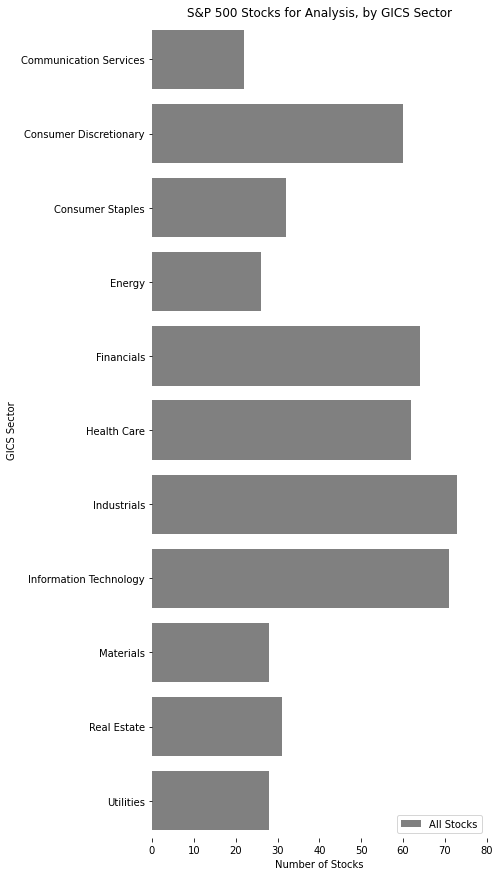

In [ ]:
# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Plotting all stocks where we have both fundamentals and price data
sns.set_color_codes("muted")
sns.barplot(x="Total", y="GICS Sector", data=df_viz_all, label="All Stocks", color="grey")

# Adding a legend and chart labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 80),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='S&P 500 Stocks for Analysis, by GICS Sector')
sns.despine(left=True, bottom=True)

### Step 1 - Filtering for stocks where current price < book value 

In [ ]:
# Step 1 - Filtering for stocks where current price < book value

# Setting up a reformatted df for the analysis
df_viz_pbtarget = df_viz.groupby(["GICS Sector","Filter PB Price Target"])["Filter PB Price Target"].count()

# Converting to a dataframe
df_viz_pbtarget = df_viz_pbtarget.to_frame()

# Renaming columns and resetting index 
df_viz_pbtarget.rename(columns={"Filter PB Price Target":"Filter PB Price Target - Pass Check"})
df_viz_pbtarget.columns= ['Stock Count']

# Some more reformatting of the dataframe for visualization
df_viz_pbtarget = df_viz_pbtarget.reset_index()
df_viz_pbtarget_fail = df_viz_pbtarget[df_viz_pbtarget["Filter PB Price Target"]==False].drop(columns=['Filter PB Price Target']).rename(columns={"Stock Count": "Price to Book - Fail"})
df_viz_pbtarget_pass = df_viz_pbtarget[df_viz_pbtarget["Filter PB Price Target"]==True].drop(columns=['Filter PB Price Target']).rename(columns={"Stock Count": "Price to Book - Pass"})
df_viz_pbtarget_final = df_viz_pbtarget_fail.merge(df_viz_pbtarget_pass, on='GICS Sector', how='outer').fillna(0)
df_viz_pbtarget_final['Price to Book - Pass'] = df_viz_pbtarget_final['Price to Book - Pass'].astype(np.int64)

# Combining to form a total column
df_viz_pbtarget_final['Total'] = df_viz_pbtarget_final['Price to Book - Fail'] + df_viz_pbtarget_final['Price to Book - Pass']
df_viz_pbtarget_final

,GICS Sector,Price to Book - Fail,Price to Book - Pass,Total
0,Communication Services,21,1,22
1,Consumer Discretionary,54,6,60
2,Consumer Staples,29,3,32
3,Energy,15,11,26
4,Financials,32,32,64
5,Health Care,61,1,62
6,Industrials,73,0,73
7,Information Technology,68,3,71
8,Materials,25,3,28
9,Real Estate,28,3,31


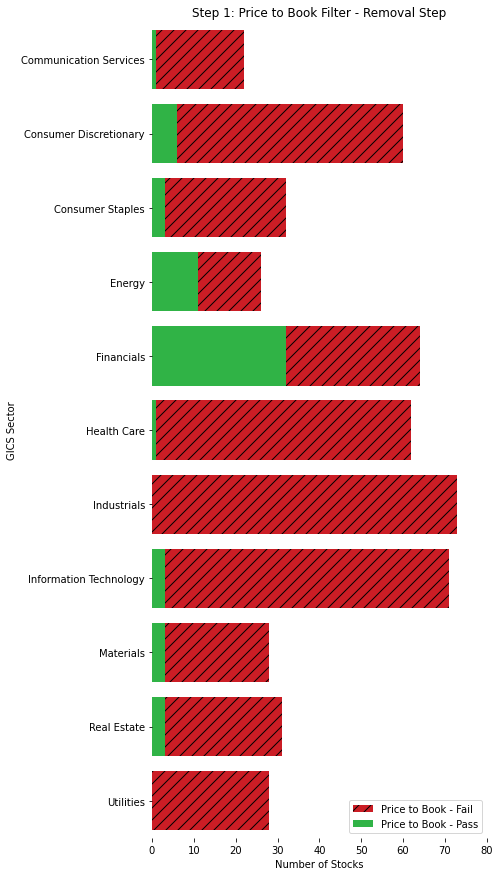

In [ ]:
# Step 1 - Price to book filtering - visualizing stocks to remove:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Visualizing the stocks to be removed
# Note - using a bit of a trick here by having the total bar as red, and, then overlaying stocks to keep. This functions as a way to display a stacked bar chart.
sns.set_color_codes("bright")
sns.barplot(x="Total", y="GICS Sector", data=df_viz_pbtarget_final, label="Price to Book - Fail", color="r",hatch="//")

# Visualizing the stocks to keep
sns.set_color_codes("bright")
sns.barplot(x="Price to Book - Pass", y="GICS Sector", data=df_viz_pbtarget_final, label="Price to Book - Pass", color="g")

# Adding a legend axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 80),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 1: Price to Book Filter - Removal Step')
sns.despine(left=True, bottom=True)

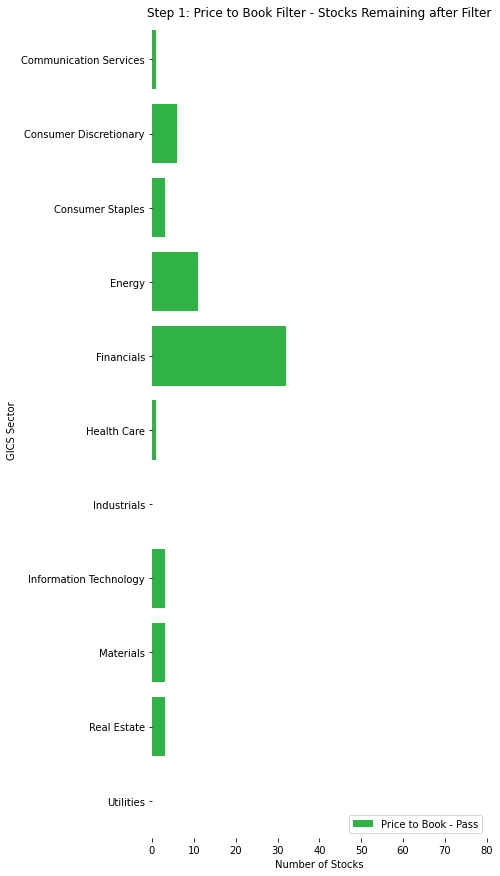

In [ ]:
# Step 1 - Price to book filtering - visualizing stocks to keep:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Commenting out the removed stocks
# sns.set_color_codes("bright")
# sns.barplot(x="Total", y="GICS Sector", data=df_viz_pbtarget_final, label="Price to Book - Fail", color="r",hatch="//")

# Now, only displaying the stocks to keep
sns.set_color_codes("bright")
sns.barplot(x="Price to Book - Pass", y="GICS Sector", data=df_viz_pbtarget_final, label="Price to Book - Pass", color="g")

# Adding a legend and axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 80),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 1: Price to Book Filter - Stocks Remaining after Filter')
sns.despine(left=True, bottom=True)

### Step 2 - Filtering for stocks where ROE > Threshold Set

In [ ]:
# Step 2 - Add on Filter on ROE threshold:
# Note, this threshold can be set in the code, but was set to ROE > 10% for the analysis.

# First filter to just the set where price to book passed in Step 1.
# We will continue to add additional filters to show how the number of stocks is being reduced.
df_viz_roe = df_viz[df_viz['Filter PB Price Target']==True]
df_viz_roe = df_viz_roe.groupby(["GICS Sector","Filter ROE"])["Filter ROE"].count()

# Converting to a dataframe
df_viz_roe = df_viz_roe.to_frame()

# Renaming columns and resetting index 
df_viz_roe.rename(columns={"Filter ROE":"Filter ROE - Pass Check"})
df_viz_roe.columns= ['Stock Count']

# Some more reformatting
df_viz_roe = df_viz_roe.reset_index()
df_viz_roe_fail = df_viz_roe[df_viz_roe["Filter ROE"]==False].drop(columns=['Filter ROE']).rename(columns={"Stock Count": "ROE Threshold - Fail"})
df_viz_roe_pass = df_viz_roe[df_viz_roe["Filter ROE"]==True].drop(columns=['Filter ROE']).rename(columns={"Stock Count": "ROE Threshold - Pass"})
df_viz_roe_final = df_viz_roe_fail.merge(df_viz_roe_pass, on='GICS Sector', how='outer').fillna(0)
df_viz_roe_final['ROE Threshold - Pass'] = df_viz_roe_final['ROE Threshold - Pass'].astype(np.int64)
df_viz_roe_final

# Combining to form a total column
df_viz_roe_final['Total'] = df_viz_roe_final['ROE Threshold - Fail'] + df_viz_roe_final['ROE Threshold - Pass']
df_viz_roe_final

,GICS Sector,ROE Threshold - Fail,ROE Threshold - Pass,Total
0,Communication Services,1,0,1
1,Consumer Discretionary,6,0,6
2,Consumer Staples,3,0,3
3,Energy,11,0,11
4,Financials,25,7,32
5,Health Care,1,0,1
6,Information Technology,2,1,3
7,Materials,3,0,3
8,Real Estate,2,1,3


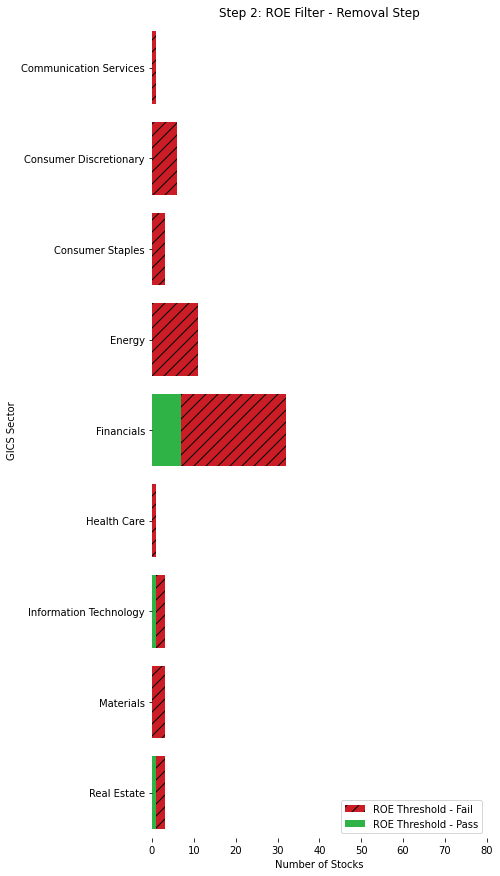

In [ ]:
# Step 2 - ROE threshold - visualizing stocks to remove:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Visualizing the stocks to be removed
# Note - using a bit of a trick here by having the total bar as red, and, then overlaying stocks to keep. This functions as a way to display a stacked bar chart. 
sns.set_color_codes("bright")
sns.barplot(x="Total", y="GICS Sector", data=df_viz_roe_final, label="ROE Threshold - Fail", color="r",hatch="//")

# Visualizing the stocks to keep
sns.set_color_codes("bright")
sns.barplot(x="ROE Threshold - Pass", y="GICS Sector", data=df_viz_roe_final, label="ROE Threshold - Pass", color="g")

# Adding a legend and axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 80),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 2: ROE Filter - Removal Step')
sns.despine(left=True, bottom=True)

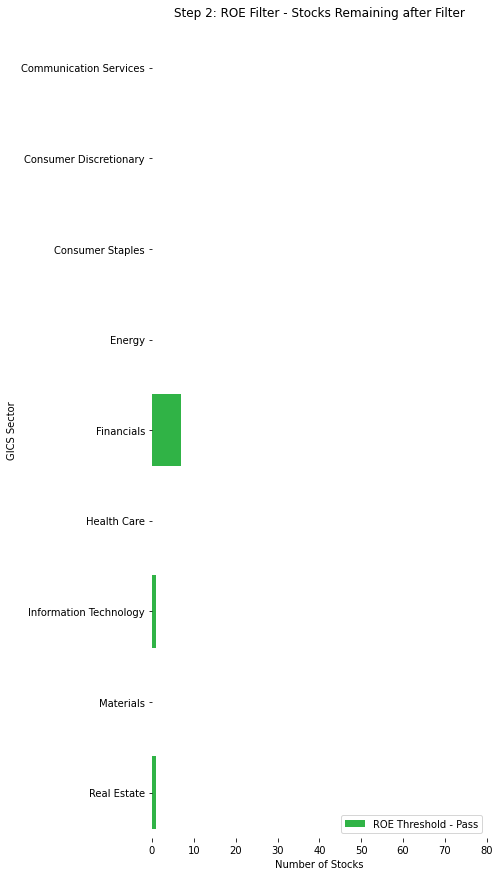

In [ ]:
# Step 2 - ROE threshold - visualizing stocks to keep:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Commenting out the removed stocks 
# sns.set_color_codes("bright")
# sns.barplot(x="Total", y="GICS Sector", data=df_viz_roe_final, label="ROE Threshold - Fail", color="r",hatch="//")

# Now, only displaying the stocks to keep 
sns.set_color_codes("bright")
sns.barplot(x="ROE Threshold - Pass", y="GICS Sector", data=df_viz_roe_final, label="ROE Threshold - Pass", color="g")

# Adding a legend axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 80),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 2: ROE Filter - Stocks Remaining after Filter')
sns.despine(left=True, bottom=True)

### Step 3 - Filtering for stocks with positive YOY ROA


In [ ]:
# Step 3 - Add on Filter for positive YOY ROA:

# Adding filters to filter down stocks for what passed the previous two checks
df_viz_roa = df_viz[df_viz['Filter PB Price Target']==True]
df_viz_roa = df_viz_roa[df_viz_roa['Filter ROE']==True]
df_viz_roa = df_viz_roa.groupby(["GICS Sector","Filter ROA"])["Filter ROA"].count()

# Converting to a dataframe
df_viz_roa = df_viz_roa.to_frame()

# Renaming columns and resetting index 
df_viz_roa.rename(columns={"Filter ROA":"Filter ROA - Pass Check"})
df_viz_roa.columns= ['Stock Count']

# Some more reformatting
df_viz_roa = df_viz_roa.reset_index()
df_viz_roa_fail = df_viz_roa[df_viz_roa["Filter ROA"]==False].drop(columns=['Filter ROA']).rename(columns={"Stock Count": "Positive ROA YOY - Fail"})
df_viz_roa_pass = df_viz_roa[df_viz_roa["Filter ROA"]==True].drop(columns=['Filter ROA']).rename(columns={"Stock Count": "Positive ROA YOY - Pass"})
df_viz_roa_final = df_viz_roa_fail.merge(df_viz_roa_pass, on='GICS Sector', how='outer').fillna(0)
df_viz_roa_final['Positive ROA YOY - Fail'] = df_viz_roa_final['Positive ROA YOY - Fail'].astype(np.int64)
df_viz_roa_final

# Combining to form a total column
df_viz_roa_final['Total'] = df_viz_roa_final['Positive ROA YOY - Fail'] + df_viz_roa_final['Positive ROA YOY - Pass']
df_viz_roa_final['Total'] = df_viz_roa_final['Total'].astype(np.int64)
df_viz_roa_final

,GICS Sector,Positive ROA YOY - Fail,Positive ROA YOY - Pass,Total
0,Financials,3,4,7
1,Information Technology,0,1,1
2,Real Estate,0,1,1


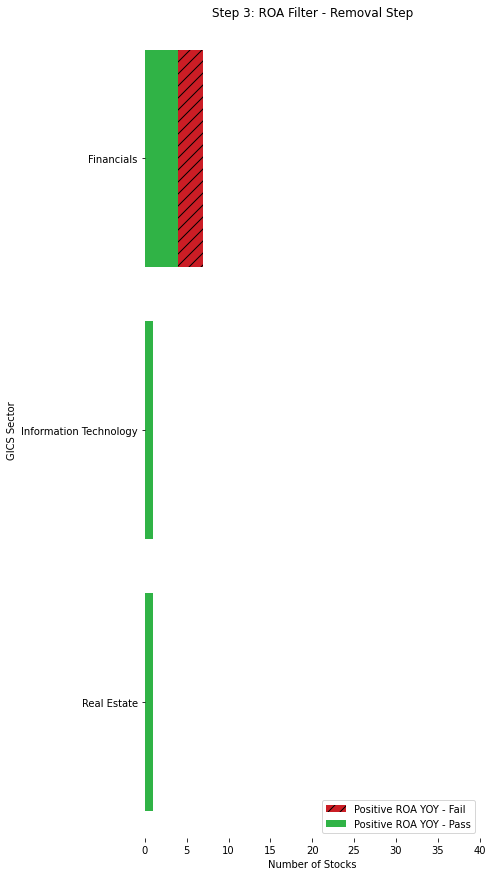

In [ ]:
# Step 3 - Positive ROA YOY - visualizing stocks to remove:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Visualizing the stocks to be removed
# Note - using a bit of a trick here by having the total bar as red, and, then overlaying stocks to keep. This functions as a way to display a stacked bar chart. 
sns.set_color_codes("bright")
sns.barplot(x="Total", y="GICS Sector", data=df_viz_roa_final, label="Positive ROA YOY - Fail", color="r",hatch="//")

# Visualizing the stocks to keep 
sns.set_color_codes("bright")
sns.barplot(x="Positive ROA YOY - Pass", y="GICS Sector", data=df_viz_roa_final, label="Positive ROA YOY - Pass", color="g")

# Adding a legend and axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 40),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 3: ROA Filter - Removal Step')
sns.despine(left=True, bottom=True)

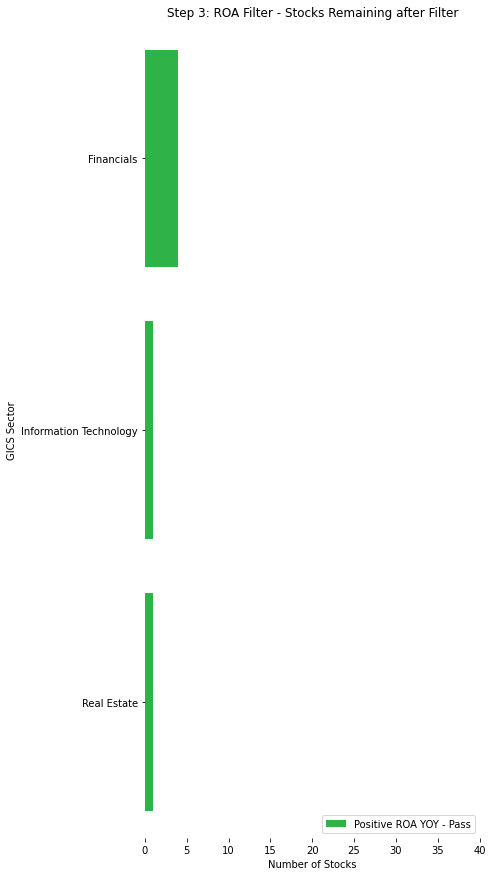

In [ ]:
# Step 3 - Positive ROA YOY - visualizing stocks to keep:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Commenting out the removed stocks  
# sns.set_color_codes("bright")
# sns.barplot(x="Total", y="GICS Sector", data=df_viz_roa_final, label="Positive ROA YOY - Fail", color="r",hatch="//")

# Now, only displaying the stocks to keep  
sns.set_color_codes("bright")
sns.barplot(x="Positive ROA YOY - Pass", y="GICS Sector", data=df_viz_roa_final, label="Positive ROA YOY - Pass", color="g")

# Adding a legend and axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 40),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 3: ROA Filter - Stocks Remaining after Filter')
sns.despine(left=True, bottom=True)

### Step 4 - Filtering for stocks with positive YOY EPS

In [ ]:
# Step 4 - Add on Filter on YOY Filter EPS:

# Adding filters to filter down stocks for what passed the previous three checks
df_viz_eps = df_viz[df_viz['Filter PB Price Target']==True]
df_viz_eps = df_viz_eps[df_viz_eps['Filter ROE']==True]
df_viz_eps = df_viz_eps[df_viz_eps['Filter ROA']==True]
df_viz_eps = df_viz_eps.groupby(["GICS Sector","Filter EPS"])["Filter EPS"].count()

# Converting to a dataframe
df_viz_eps = df_viz_eps.to_frame()

# Renaming columns and resetting index 
df_viz_eps.rename(columns={"Filter EPS":"Filter EPS - Pass Check"})
df_viz_eps.columns= ['Stock Count']

# Some more reformatting
df_viz_eps = df_viz_eps.reset_index()
df_viz_eps_fail = df_viz_eps[df_viz_eps["Filter EPS"]==False].drop(columns=['Filter EPS']).rename(columns={"Stock Count": "Positive EPS YOY - Fail"})
df_viz_eps_pass = df_viz_eps[df_viz_eps["Filter EPS"]==True].drop(columns=['Filter EPS']).rename(columns={"Stock Count": "Positive EPS YOY - Pass"})
df_viz_eps_final = df_viz_eps_fail.merge(df_viz_eps_pass, on='GICS Sector', how='outer').fillna(0)
df_viz_eps_final['Positive EPS YOY - Fail'] = df_viz_eps_final['Positive EPS YOY - Fail'].astype(np.int64)
df_viz_eps_final

# Combining to form a total column
df_viz_eps_final['Total'] = df_viz_eps_final['Positive EPS YOY - Fail'] + df_viz_eps_final['Positive EPS YOY - Pass']
df_viz_eps_final['Total'] = df_viz_eps_final['Total'].astype(np.int64)
df_viz_eps_final

,Positive EPS YOY - Fail,GICS Sector,Positive EPS YOY - Pass,Total
0,0,Financials,4,4
1,0,Information Technology,1,1
2,0,Real Estate,1,1


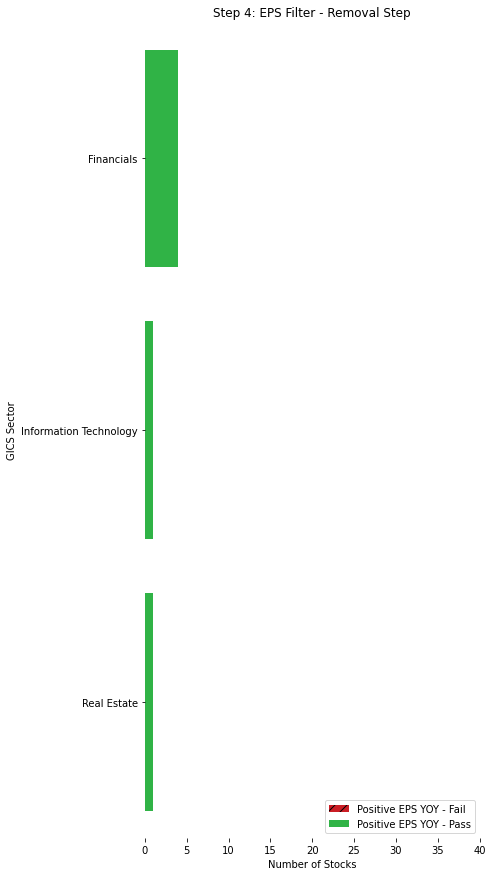

In [ ]:
# Step 4 - Positive EPS YOY - visualizing stocks to remove:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Visualizing the stocks to be removed
# Note - using a bit of a trick here by having the total bar as red, and, then overlaying stocks to keep. This functions as a way to display a stacked bar chart. 
sns.set_color_codes("bright")
sns.barplot(x="Total", y="GICS Sector", data=df_viz_eps_final, label="Positive EPS YOY - Fail", color="r",hatch="//")

# Visualizing the stocks to keep  
sns.set_color_codes("bright")
sns.barplot(x="Positive EPS YOY - Pass", y="GICS Sector", data=df_viz_eps_final, label="Positive EPS YOY - Pass", color="g")

# Adding a legend axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 40),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 4: EPS Filter - Removal Step')
sns.despine(left=True, bottom=True)

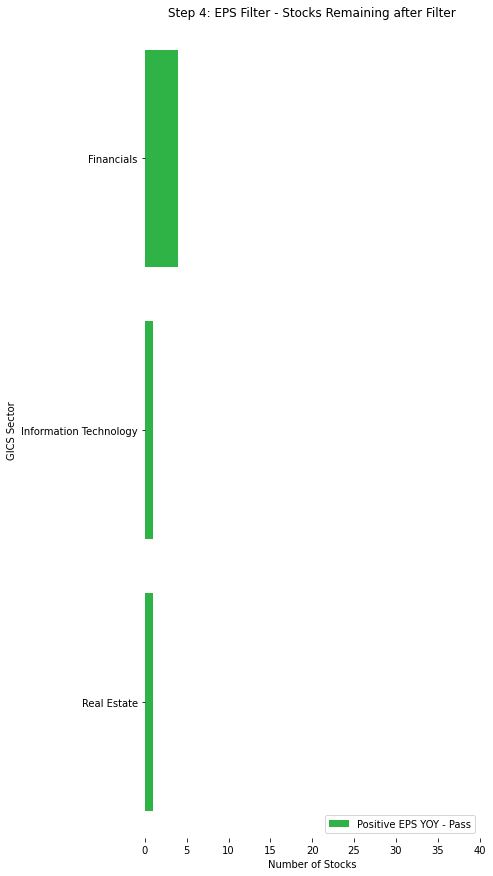

In [ ]:
# Step 4 - Positive EPS YOY - visualizing stocks to keep:

# Setting up seaborn
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 15))

# Commenting out the removed stocks  
# sns.set_color_codes("bright")
# sns.barplot(x="Total", y="GICS Sector", data=df_viz_eps_final, label="Positive EPS YOY - Fail", color="r",hatch="//")

# Now, only displaying the stocks to keep  
sns.set_color_codes("bright")
sns.barplot(x="Positive EPS YOY - Pass", y="GICS Sector", data=df_viz_eps_final, label="Positive EPS YOY - Pass", color="g")

# Adding a legend and axis labels
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 40),
       ylabel="GICS Sector",
       xlabel="Number of Stocks",
       title='Step 4: EPS Filter - Stocks Remaining after Filter')
sns.despine(left=True, bottom=True)